In [25]:
from sklearn import datasets
from sklearn.model_selection import train_test_split
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

X, y = datasets.make_classification(n_features=2, n_informative=2, n_classes=2,
                                    n_redundant=0, n_clusters_per_class=1, n_samples=500)

X_train, X_test, y_train, y_test = train_test_split(X, y)

In [26]:
class Node:
    def __init__(self, feature=None, threshold=None, left=None, right=None, *, value=None):
        self.feature = feature
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value
        
    def is_leaf_node(self):
        return self.value is not None

In [30]:
class DecisionTree:
    def __init__(self, max_depth=100, min_samples=10):
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.tree = None
    
    def fit(self, X, y):
        self.tree = self.grow_tree(X, y)
    
    def predict(self, X):
        return np.array([self.travers_tree(x, self.tree) for x in X])
    
    def entropy(self, y):
        c = np.sum(y) / len(y)
        mse = np.sum((c - y)**2) / len(y)
        mae = np.sum(np.abs(c - y)) / len(y)
        return mse
    
    def most_common(self, y):
        c = np.sum(y) / len(y)
        return c
    
    def best_split(self, X, y):
        best_feature, best_threshold = None, None
        best_gain = -1
        
        for i in range(X.shape[1]):
            thresholds = np.unique(X[:, i])
            for threshold in thresholds:
                gain = self.information_gain(X[:, i], y, threshold)
                if gain > best_gain:
                    best_gain = gain
                    best_feature = i
                    best_threshold = threshold
        return best_feature, best_threshold
    
    def information_gain(self, X_column, y, threshold):               
        n = len(y)
        parent = self.entropy(y)
        
        left_indexes = np.argwhere(X_column <= threshold).flatten()
        right_indexes = np.argwhere(X_column > threshold).flatten()
        
        if len(left_indexes) == 0 or len(right_indexes) == 0:
            return 0
        
        e_l, n_l = self.entropy(y[left_indexes]), len(left_indexes)
        e_r, n_r = self.entropy(y[right_indexes]), len(right_indexes)
        
        child = (n_l / n) * e_l + (n_r / n) * e_r
        return parent - child
    
    def grow_tree(self, X, y, depth=0):
        n_samples = len(y)
        n_labels = len(np.unique(y))
         
        if n_labels == 1 or depth >= self.max_depth or n_samples <= self.min_samples:
            return Node(value=self.most_common(y))
        
        best_feature, best_threshold = self.best_split(X, y)
        
        left_indexes = np.argwhere(X[:, best_feature] <= best_threshold).flatten()
        right_indexes = np.argwhere(X[:, best_feature] > best_threshold).flatten()
        
        left = self.grow_tree(X[left_indexes, :], y[left_indexes], depth+1)
        right = self.grow_tree(X[right_indexes, :], y[right_indexes], depth+1)
        
        return Node(best_feature, best_threshold, left, right)
    
    def travers_tree(self, x, tree):
        if tree.is_leaf_node():
            return tree.value
        
        if x[tree.feature] < tree.threshold:
            return self.travers_tree(x, tree.left)
        return self.travers_tree(x, tree.right)

In [31]:
class GBT:
    def __init__(self, n_estimators=100, max_depth=3, min_samples=10, lr=0.1):
        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples = min_samples
        self.trees = []
        self.residuals = []
        self.lr = lr
        self.first_leaf = None
        self.train_score = []
        
    def fit(self, X, y):
        self.first_leaf = y.mean()
        predictions = np.ones(len(y)) * self.first_leaf
        
        for i in range(self.n_estimators):
            residuals = y - predictions
            self.residuals.append(residuals)
            
            tree = DecisionTree(max_depth = self.max_depth, min_samples = self.min_samples)
            tree.fit(X, residuals)
            self.trees.append(tree)
            
            predictions += self.lr * tree.predict(X)
            self.train_score.append(self.score(self.predict(X, len(self.trees)), y))
            
    def predict(self, X, n=None):           
        if n is None:
            n = self.n_estimators
        predictions = np.ones(X.shape[0]) * self.first_leaf
        
        for i in range(n):
            predictions += self.lr * self.trees[i].predict(X)
        
        threshold = predictions.mean()
        labels = [0 if i <= threshold else 1 for i in predictions]
        
        return np.array(labels)
    
    def score(self, predicted, y):
        return np.sum(predicted == y) / len(y)
    
    def roc(self, X, y):
        predictions = np.ones(X.shape[0]) * self.first_leaf
        
        for i in range(self.n_estimators):
            predictions += self.lr * self.trees[i].predict(X)        
            
        indexes = np.argsort(predictions)
        
        TPR = []
        FPR = []
        
        for threshold in predictions[indexes]:
            labels = [0 if i <= threshold else 1 for i in predictions]
            
            TP, FP, TN, FN = 0, 0, 0, 0
            
            for i in range(len(labels)):
                if labels[i] == 0 and y[i] == 0: TP += 1
                if labels[i] == 1 and y[i] == 1: TN += 1
                if labels[i] == 0 and y[i] == 1: FP += 1
                if labels[i] == 1 and y[i] == 0: FN += 1
            
            TPR.append(TP / (TP + FN))
            FPR.append(FP / (FP + TN))
        
        return TPR, FPR

In [32]:
reg = GBT(n_estimators=100)
reg.fit(X_train, y_train)

predicted = reg.predict(X_test)
print(reg.score(predicted, y_test))

0.944


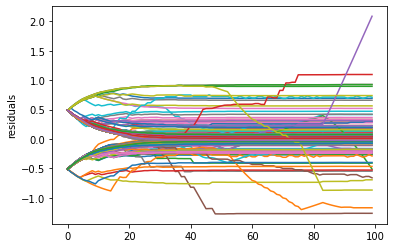

In [33]:
plt.plot(reg.residuals)
plt.ylabel("residuals")
plt.show()

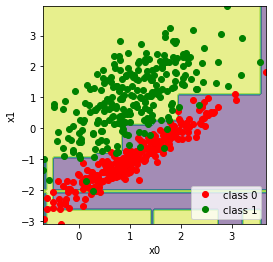

In [34]:
def back_ground(model, X):
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()

    step = 100

    xx, yy = np.meshgrid(np.arange(x_min, x_max + (x_max-x_min) / step, (x_max-x_min) / step),
                         np.arange(y_min, y_max + (y_max-y_min) / step, (y_max-y_min) / step))

    Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)    
    
    return xx, yy, Z

xx, yy, Z = back_ground(reg, X)

fig, axs = plt.subplots(figsize=(4, 4))

plt.plot(X[y==0, 0], X[y==0, 1], "or", label="class 0")
plt.plot(X[y==1, 0], X[y==1, 1], "og", label="class 1")
# plt.plot(X[y==2, 0], X[y==2, 1], "ob", label="class 2")
# plt.plot(X[y==3, 0], X[y==3, 1], "ok", label="class 3")
plt.contourf(xx, yy, Z, alpha=0.5)
plt.legend()
plt.xlabel("x0")
plt.ylabel("x1")
plt.show()

In [7]:
test_score = []

for i in range(reg.n_estimators):
    test_score.append(reg.score(reg.predict(X_test, i), y_test))

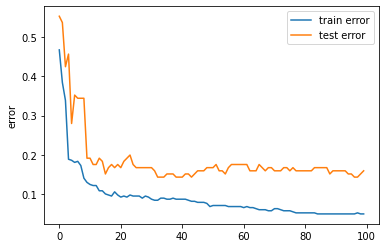

In [8]:
plt.plot(1 - np.array(reg.train_score), label="train error")
plt.plot(1 - np.array(test_score), label="test error")
plt.legend()
plt.ylabel("error")
plt.show()

In [9]:
TPR, FPR = reg.roc(X_test, y_test)

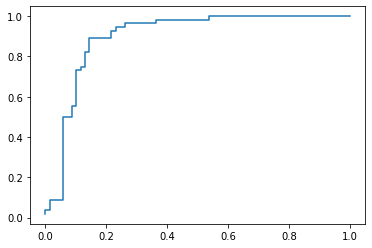

In [10]:
plt.plot(FPR, TPR)
plt.show()